In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch_geometric as tg
import pysmiles
import torch.optim as optim
%matplotlib inline
import rdkit

# import packages

# general tools
import numpy as np

# RDkit
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

# Pytorch and Pytorch Geometric
import torch
from torch_geometric.data import Data
from torch.utils.data import DataLoader

In [2]:
# open the molecule data
df = pd.read_csv("C:/Users/sagar/Documents/molecular_data.csv")
df.head()

Number of Atoms                                          CSD_Label Atom  \
0               77  CSD_code = GIQVAG | q = 0 | S = 0 | Stoichiome...   Ir   
1               77  CSD_code = GIQVAG | q = 0 | S = 0 | Stoichiome...    O   
2               77  CSD_code = GIQVAG | q = 0 | S = 0 | Stoichiome...    O   
3               77  CSD_code = GIQVAG | q = 0 | S = 0 | Stoichiome...    N   
4               77  CSD_code = GIQVAG | q = 0 | S = 0 | Stoichiome...    N   

          X         Y          Z  
0  5.830300  3.029099  16.717265  
1  4.591596  4.113017  15.213939  
2  4.102707  3.441509  18.051009  
3  6.651509  4.646264  17.527821  
4  5.003926  1.431850  15.851927

In [3]:
# open SMILES data
smiles = pd.read_csv("C:/Users/sagar/Documents/input_smiles.csv")
smiles.head()

atoms                                             SMILES CSD_code  q  S  \
0    116  [La]1(N(c2c(cccc2C(C)C)C(C)C)[C](N1c1c(cccc1C(...   WIXKOE  0  0   
1     42  [Sc]123(ON(O1)[O])(ON([O])O2)ON([O])O3.n1ccccc...   DUCVIG  0  0   
2     73  [La]123(O[C](C=C(O1)C(F)(F)F)C(F)(F)F)(OC(=C[C...   KINJOG  0  0   
3     46  [Sc]123(OC(=C[C](O1)C(F)(F)F)C(F)(F)F)(O[C](C(...   GEKYEC  0  0   
4     72  n1([Y][C@@]2([C](C(=C([C]2C)C)C)C)C)c(c(c(c1C)...   PIBNEV  0  0   

    Stoichiometry  MND  
0     C47H65LaN2O    7  
1    C13H10N9O9Sc    8  
2  C23H21F18LaO10   10  
3    C15H5F18O7Sc    7  
4        C28H42NY   11

[La]123(O[C](C=C(O1)C(F)(F)F)C(F)(F)F)(OC(=C[C](O2)C(F)(F)F)C(F)(F)F)O[C](C=C(O3)C(F)(F)F)C(F)(F)F.O(C)CCOCCOCCOC


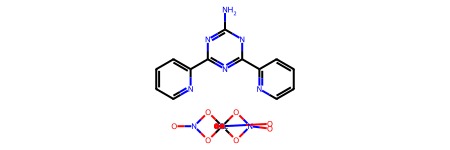

In [4]:
smiles_list = smiles['SMILES'].tolist()
mol = Chem.MolFromSmiles(smiles_list[1],sanitize=False)
print (smiles_list[2])
mol

In [5]:
# Open property data
prop = pd.read_csv("C:/Users/sagar/Documents/new_quality.csv")

In [6]:
def one_hot_encoding(x, permitted_list):
    """
    Maps input elements x which are not in the permitted list to the last element
    of the permitted list.
    """
    if x not in permitted_list:
        x = permitted_list[-1]
    binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]
    return binary_encoding

In [7]:
def get_atom_features(atom, 
                      use_chirality = True, 
                      hydrogens_implicit = True):
    """
    Takes an RDKit atom object as input and gives a 1d-numpy array of atom features as output.
    """

    # define list of permitted atoms
    
    permitted_list_of_atoms =  ['C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca','Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt','Hg','Pb','Unknown']
    
    if hydrogens_implicit == False:
        permitted_list_of_atoms = ['H'] + permitted_list_of_atoms
    
    # compute atom features
    
    atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)
    
    n_heavy_neighbors_enc = one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])
    
    formal_charge_enc = one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"])
    
    hybridisation_type_enc = one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])
    
    is_in_a_ring_enc = [int(atom.IsInRing())]
    
    is_aromatic_enc = [int(atom.GetIsAromatic())]
    
    atomic_mass_scaled = [float((atom.GetMass() - 10.812)/116.092)]
    
    vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)]
    
    covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)]

    atom_feature_vector = atom_type_enc + n_heavy_neighbors_enc + formal_charge_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled
                                    
    if use_chirality == True:
        chirality_type_enc = one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
        atom_feature_vector += chirality_type_enc
    
    if hydrogens_implicit == True:
        n_hydrogens_enc = one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
        atom_feature_vector += n_hydrogens_enc

    return np.array(atom_feature_vector)

In [8]:
def get_bond_features(bond, 
                      use_stereochemistry = True):
    """
    Takes an RDKit bond object as input and gives a 1d-numpy array of bond features as output.
    """

    permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

    bond_type_enc = one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)
    
    bond_is_conj_enc = [int(bond.GetIsConjugated())]
    
    bond_is_in_ring_enc = [int(bond.IsInRing())]
    
    bond_feature_vector = bond_type_enc + bond_is_conj_enc + bond_is_in_ring_enc
    
    if use_stereochemistry == True:
        stereo_type_enc = one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
        bond_feature_vector += stereo_type_enc

    return np.array(bond_feature_vector)

In [9]:
def create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_smiles, y):
    """
    Inputs:
    
    x_smiles = [smiles_1, smiles_2, ....] ... a list of SMILES strings
    y = [y_1, y_2, ...] ... a list of numerial labels for the SMILES strings (such as associated pKi values)
    
    Outputs:
    
    data_list = [G_1, G_2, ...] ... a list of torch_geometric.data.Data objects which represent labeled molecular graphs that can readily be used for machine learning
    
    """
    
    data_list = []
    
    for (smiles, y_val) in zip(x_smiles, y):
        
        # convert SMILES to RDKit mol object
        mol = Chem.MolFromSmiles(smiles, sanitize = True)
        if mol is not None:
            # get feature dimensions
            n_nodes = mol.GetNumAtoms()
            n_edges = 2*mol.GetNumBonds()
            unrelated_smiles = "O=O"
            unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
            n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
            n_edge_features = len(get_bond_features(unrelated_mol.GetBondBetweenAtoms(0,1)))

            # construct node feature matrix X of shape (n_nodes, n_node_features)
            X = np.zeros((n_nodes, n_node_features))

            for atom in mol.GetAtoms():
                X[atom.GetIdx(), :] = get_atom_features(atom)
                
            X = torch.tensor(X, dtype = torch.float)
            
            # construct edge index array E of shape (2, n_edges)
            (rows, cols) = np.nonzero(GetAdjacencyMatrix(mol))
            torch_rows = torch.from_numpy(rows.astype(np.int64)).to(torch.long)
            torch_cols = torch.from_numpy(cols.astype(np.int64)).to(torch.long)
            E = torch.stack([torch_rows, torch_cols], dim = 0)
            
            # construct edge feature array EF of shape (n_edges, n_edge_features)
            EF = np.zeros((n_edges, n_edge_features))
            
            for (k, (i,j)) in enumerate(zip(rows, cols)):
                
                EF[k] = get_bond_features(mol.GetBondBetweenAtoms(int(i),int(j)))
            
            EF = torch.tensor(EF, dtype = torch.float)
            
            # construct label tensor
            y_tensor = torch.tensor(np.array([y_val]), dtype = torch.float)
            
            # construct Pytorch Geometric data object and append to data list
            data_list.append(Data(x = X, edge_index = E, edge_attr = EF, y = y_tensor))

    return data_list

In [10]:
# Check if SMILES string is valid in entire dataset and filter out invalid SMILES Strings and associated labels from quality

def check_smiles_validity(smiles):
    """
    Takes a SMILES string as input and returns True if the SMILES string is valid and False otherwise.
    """
    mol = Chem.MolFromSmiles(smiles, sanitize = True)
    if mol is None:
        return False
    else:
        return True

# check if SMILES string is valid in entire dataset and filter out invalid SMILES Strings 

smiles['Valid'] = smiles['SMILES'].apply(lambda x: check_smiles_validity(x))

[14:40:08] Explicit valence for atom # 20 N, 4, is greater than permitted
[14:40:08] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:40:08] Explicit valence for atom # 3 N, 4, is greater than permitted
[14:40:08] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:40:08] Explicit valence for atom # 24 B, 4, is greater than permitted
[14:40:08] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:40:08] Explicit valence for atom # 10 N, 4, is greater than permitted
[14:40:08] Explicit valence for atom # 0 B, 4, is greater than permitted
[14:40:08] Explicit valence for atom # 22 B, 4, is greater than permitted
[14:40:08] Explicit valence for atom # 6 B, 4, is greater than permitted
[14:40:08] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:40:08] Explicit valence for atom # 8 N, 4, is greater than permitted
[14:40:08] Explicit valence for atom # 8 N, 4, is greater than permitted
[14:40:08] Explicit valence for atom # 30 N, 4,

In [11]:
smiles.Valid.value_counts()

True     70263
False    16402
Name: Valid, dtype: int64

In [12]:
new_smiles = smiles[smiles['Valid'] == True]
new_smiles.to_csv('C:/Users/sagar/Documents/updated_smiles.csv',index=False)

In [13]:
prop['SMILES'] = smiles['SMILES']
prop['Valid'] = prop['SMILES'].apply(lambda x: check_smiles_validity(x))


[14:40:35] Explicit valence for atom # 20 N, 4, is greater than permitted
[14:40:35] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:40:35] Explicit valence for atom # 3 N, 4, is greater than permitted
[14:40:35] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:40:35] Explicit valence for atom # 24 B, 4, is greater than permitted
[14:40:35] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:40:35] Explicit valence for atom # 10 N, 4, is greater than permitted
[14:40:35] Explicit valence for atom # 0 B, 4, is greater than permitted
[14:40:35] Explicit valence for atom # 22 B, 4, is greater than permitted
[14:40:35] Explicit valence for atom # 6 B, 4, is greater than permitted
[14:40:35] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:40:35] Explicit valence for atom # 8 N, 4, is greater than permitted
[14:40:35] Explicit valence for atom # 8 N, 4, is greater than permitted
[14:40:35] Explicit valence for atom # 30 N, 4,

In [14]:
# canonical training loop for a Pytorch Geometric GNN model gnn_model

# create list of molecular graph objects from list of SMILES x_smiles and list of labels y
data_list = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(smiles['SMILES'].tolist(), prop['Metal_q'].tolist())

[14:41:00] Explicit valence for atom # 20 N, 4, is greater than permitted
[14:41:00] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:41:00] Explicit valence for atom # 3 N, 4, is greater than permitted
[14:41:00] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:41:00] Explicit valence for atom # 24 B, 4, is greater than permitted
[14:41:00] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:41:00] Explicit valence for atom # 10 N, 4, is greater than permitted
[14:41:00] Explicit valence for atom # 0 B, 4, is greater than permitted
[14:41:00] Explicit valence for atom # 22 B, 4, is greater than permitted
[14:41:00] Explicit valence for atom # 6 B, 4, is greater than permitted
[14:41:00] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:41:00] Explicit valence for atom # 8 N, 4, is greater than permitted
[14:41:00] Explicit valence for atom # 8 N, 4, is greater than permitted
[14:41:00] Explicit valence for atom # 30 N, 4,

In [15]:
len(data_list)

70263

In [16]:
data_list[0].edge_attr

tensor([[1., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 1.]])

In [17]:
from torch.utils.data import random_split
from torch_geometric.data import DataLoader
train_set, valid_set, test_set = random_split(
    data_list,[40000, 20000, 10263])
trainloader = DataLoader(train_set, batch_size=32, shuffle=True)
validloader = DataLoader(valid_set, batch_size=32, shuffle=True)
testloader = DataLoader(test_set, batch_size=32, shuffle=True)

c:\Users\sagar\anaconda3\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [18]:
# Build graph neural network using pytocrch geometric on graph data

import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn as nn

class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(79, 64)
        self.conv2 = GCNConv(64, 32)
        self.conv3 = GCNConv(32, 16)
        self.conv4 = GCNConv(16, 8)
        self.fc1 = Linear(8, 4)
        self.fc2 = Linear(4, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = global_mean_pool(x, data.batch)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

'''
class SGConv(torch.nn.Module):
    def __init__(self):
        super(SGConv, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = SGConv(79, 64, K=2)
        self.conv2 = SGConv(64, 8, K=2)
        self.fc1 = Linear(8, 4)
        self.fc2 = Linear(4, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, data.batch)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x
'''

'\nclass SGConv(torch.nn.Module):\n    def __init__(self):\n        super(SGConv, self).__init__()\n        torch.manual_seed(12345)\n        self.conv1 = SGConv(79, 64, K=2)\n        self.conv2 = SGConv(64, 8, K=2)\n        self.fc1 = Linear(8, 4)\n        self.fc2 = Linear(4, 1)\n\n    def forward(self, data):\n        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr\n        x = F.relu(self.conv1(x, edge_index))\n        x = F.relu(self.conv2(x, edge_index))\n        x = global_mean_pool(x, data.batch)\n        x = F.relu(self.fc1(x))\n        x = F.dropout(x, training=self.training)\n        x = self.fc2(x)\n        return x\n'

In [19]:
gnn_model = GNN()
gnn_model

GNN(
  (conv1): GCNConv(79, 64)
  (conv2): GCNConv(64, 32)
  (conv3): GCNConv(32, 16)
  (conv4): GCNConv(16, 8)
  (fc1): Linear(in_features=8, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=1, bias=True)
)

In [20]:
import torch.nn as nn

# define loss function
loss_function = nn.MSELoss(reduction='mean')

# define optimiser
optimiser = torch.optim.Adam(gnn_model.parameters(), lr = 0.011584)

# loop over 10 training epochs
for epoch in range(10):
        val_running_loss = 0.0
        running_loss = 0.0
        # set model to training mode
        gnn_model.train()
    
        # loop over minibatches for training
        for (k, batch) in enumerate(trainloader):
    
            # compute current value of loss function via forward pass
            output = gnn_model(batch)
            loss_function_value = loss_function(output[:,0], torch.tensor(batch.y, dtype = torch.float32))

            running_loss += loss_function_value.item()
    
            # set past gradient to zero
            optimiser.zero_grad()
    
            # compute current gradient via backward pass
            loss_function_value.backward()
    
            # update model weights using gradient and optimisation method
            optimiser.step()

        # Print training loss
        print('Epoch: {:03d}, Loss: {:.5f}'.format(epoch, running_loss/len(trainloader)))

        gnn_model.eval()
        with torch.no_grad():
            for (k, batch) in enumerate(validloader):
                val_loss = loss_function(output[:,0], torch.tensor(batch.y, dtype = torch.float32))    
                val_running_loss += val_loss.item()
            
        avg_val_loss = val_running_loss / len(validloader)

        print ('Epoch: {:03d}, Validation Loss: {:.5f}'.format(epoch,avg_val_loss))  

C:\Users\sagar\AppData\Local\Temp\ipykernel_17820\2514438414.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_function_value = loss_function(output[:,0], torch.tensor(batch.y, dtype = torch.float32))


Epoch: 000, Loss: 0.46405


C:\Users\sagar\AppData\Local\Temp\ipykernel_17820\2514438414.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_loss = loss_function(output[:,0], torch.tensor(batch.y, dtype = torch.float32))


Epoch: 000, Validation Loss: 0.89953
Epoch: 001, Loss: 0.40605
Epoch: 001, Validation Loss: 0.95465
Epoch: 002, Loss: 0.36244
Epoch: 002, Validation Loss: 0.77249
Epoch: 003, Loss: 0.33658
Epoch: 003, Validation Loss: 1.01258
Epoch: 004, Loss: 0.33280
Epoch: 004, Validation Loss: 0.85696
Epoch: 005, Loss: 0.32910
Epoch: 005, Validation Loss: 0.86149
Epoch: 006, Loss: 0.32681
Epoch: 006, Validation Loss: 0.90772
Epoch: 007, Loss: 0.32498
Epoch: 007, Validation Loss: 1.23619
Epoch: 008, Loss: 0.32790
Epoch: 008, Validation Loss: 0.98882
Epoch: 009, Loss: 0.32050
Epoch: 009, Validation Loss: 0.78654


In [21]:
# Evaluate model on test set

def evaluate(model, loader):
    model.eval()
    error = 0
    for data in loader:
        pred = model(data)
        error += loss_function(pred, data.y).item()
    return error / len(loader)

print('Test Error: {:.4f}'.format(evaluate(gnn_model, testloader)))

c:\Users\sagar\anaconda3\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 0.8316


c:\Users\sagar\anaconda3\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[array([[-0.13014507],
       [ 0.03013629],
       [ 0.33127707],
       [ 0.27037084],
       [-0.4660694 ],
       [ 0.43009496],
       [-1.1725473 ],
       [-0.0439617 ],
       [-0.13588929],
       [ 0.43009496],
       [ 0.43009496],
       [ 0.43009496],
       [ 0.43009496],
       [ 0.24647754],
       [-0.55214393],
       [-0.38238406],
       [-0.1387183 ],
       [ 0.43009496],
       [-0.2538587 ],
       [-1.0022259 ],
       [-0.51268256],
       [-1.458848  ],
       [-0.7374053 ],
       [-0.54831266],
       [-0.2368961 ],
       [ 0.3365303 ],
       [ 0.35036734],
       [-0.14167964],
       [ 0.2501669 ],
       [-0.8670685 ],
       [ 0.43009496],
       [ 0.43009496]], dtype=float32), array([[-1.0366709 ],
       [ 0.19659208],
       [ 0.32284614],
       [-0.4655288 ],
       [ 0.43009496],
       [ 0.43009496],
       [ 0.32671407],
       [-0.22118223],
       [-0.5396342 ],
       [ 0.43009496],
       [-0.41467237],
       [-0.950874  ],
       [ 0.353

(array([[-0.13014507],
        [ 0.03013629],
        [ 0.33127707],
        ...,
        [ 0.41345218],
        [ 0.346663  ],
        [ 0.18364522]], dtype=float32),
 array([-0.3613 , -0.26315,  0.22728, ...,  0.94473,  0.09791,  0.47951],
       dtype=float32))

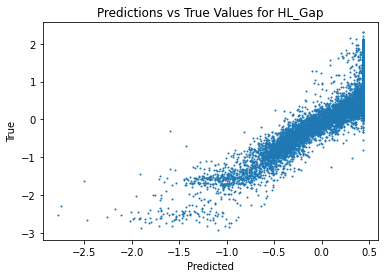

In [22]:
# Plot predictions against true values

import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(model, loader):
    model.eval()
    y_pred = []
    y_true = []
    for i,data in enumerate(loader):
        pred = model(data)
        y_pred.append(pred.detach().numpy())
        y_true.append(data.y.detach().numpy())
    y_pred = list(np.array(y_pred,dtype=object).flatten())
    y_true = list(np.array(y_true,dtype=object).flatten())
    
    print (y_pred)
    # Concatenate list of numpy arrays across axis 0
    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)

    # Plot predictions against true values
    plt.scatter(y_pred, y_true, s=1)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Predictions vs True Values for HL_Gap')

    return y_pred, y_true
plot_predictions(gnn_model, testloader)

Using Optuna

In [23]:
import optuna

In [24]:
# Build different GCN models with different hyperparameters of layers
def build_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []
    # Create graph convolutional layers
    for i in range(n_layers):
        in_channels = 79 if i == 0 else out_channels
        out_channels = trial.suggest_int("n_units_l{}".format(i), 4, 64)
        layers.append(GCNConv(in_channels, out_channels))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)))
    layers.append(Linear(out_channels, 1))
    return nn.Sequential(*layers)

In [25]:
def objective(trial):


    # Generate the optimizers
    params = {"optimizer_name": trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD']),
    "lr" : trial.suggest_loguniform('lr', 1e-5, 1e-1)
}
    
    model = build_model(trial)
    optimizer = getattr(optim, params['optimizer_name'])(model.parameters(), lr=params['lr'])


    criterion = nn.MSELoss()

    # loop over 10 training epochs
    for epoch in range(10):
            running_loss = 0
            val_running_loss = 0
            # set model to training mode
            model.train()
        
            # loop over minibatches for training
            for (k, batch) in enumerate(trainloader):
        
                # compute current value of loss function via forward pass
                output = model.forward(batch)
                loss_function_value = criterion(output[:,0], torch.tensor(batch.y, dtype = torch.float32))
        
                # set past gradient to zero
                optimizer.zero_grad()

                running_loss += loss_function_value.item()
        
                # compute current gradient via backward pass
                loss_function_value.backward()
        
                # update model weights using gradient and optimisation method
                optimizer.step()

            avg_loss = running_loss / len(trainloader)
            trial.report(avg_loss, epoch)

            with torch.no_grad():
                for (k, batch) in enumerate(validloader):
                    output = model.forward(batch)
                    val_loss = criterion(output[:,0], torch.tensor(batch.y, dtype = torch.float32))    
                    val_running_loss += val_loss.item()

            avg_val_loss = val_running_loss / len(validloader)

            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
    return avg_val_loss

In [26]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

trial = study.best_trial
print ('Best trial: score {},\nparams {}'.format(trial.value, trial.params))
print ('Best Hyperparameters: {}'.format(study.best_params))

[I 2022-12-06 14:47:12,853] A new study created in memory with name: no-name-5e6ba54b-c700-438b-a9b6-8d8f9a31b068
C:\Users\sagar\AppData\Local\Temp\ipykernel_17820\1418470921.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "lr" : trial.suggest_loguniform('lr', 1e-5, 1e-1)
[W 2022-12-06 14:47:12,879] Trial 0 failed because of the following error: TypeError("forward() missing 1 required positional argument: 'edge_index'")
Traceback (most recent call last):
  File "c:\Users\sagar\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\sagar\AppData\Local\Temp\ipykernel_17820\1418470921.py", line 26, in objective
    output = model.forward(batch)
  File "c:\Users\sagar\anaconda3\lib\site-packages\torch\nn\modules\container.py", line 139, in 

TypeError: forward() missing 1 required positional argument: 'edge_index'

In [ ]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))
  
# learning_rate: 0.01271391756622307
# optimizer: RMSprop
# n_layers: 1
# n_units_l0: 8

optimizer: RMSprop
lr: 0.0005314871053877372
layers: 3
